In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys
import pickle
import time

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertModel
import matplotlib.pyplot as plt

sys.path.append('code')
sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab3-group6/code")

from preprocessing import downsample_word_vectors, make_delayed

torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data' # Path where data files are stored
ckpt_path = '/ocean/projects/mth240012p/azhang19/lab3/ckpts'

In [2]:
# %% Load preprocessed word sequences (likely includes words and their timings)
with open(f'{data_path}/raw_text.pkl', 'rb') as file:
    wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}

# %% Get list of story identifiers and split into training and testing sets
# Assumes story data for 'subject2' exists and filenames are story IDs + '.npy'
stories = [i[:-4] for i in os.listdir(f'{data_path}/subject2')] # Extract story IDs from filenames
# Split stories into train and test sets with a fixed random state for reproducibility


# First, use 60% for training and 40% for the remaining data.
train_stories, test_stories = train_test_split(stories, train_size=0.75, random_state=214)

/tmp/ipykernel_1459174/46575173.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}


In [11]:
dims = [32, 64]
mlm_probs = [0.1, 0.15, 0.2]
epochs = 1000 # Assuming all records are for 1000 epochs as per filename

all_records = {} # Dictionary to store records: all_records[mlm_prob][dim]

for prob in mlm_probs:
    all_records[prob] = {}
    for dim_val in dims:
        filename = f"dim{dim_val}_mlm{prob}_epoch{epochs}.pth"
        file_path = os.path.join(ckpt_path, filename)
        # Load only the record, model isn't needed for plotting
        # Ensure map_location is set if records contain tensors
        _model, record = torch.load(file_path, weights_only=False, map_location=device)
        # Ensure record is usable (e.g., convert tensors to numpy if needed)
        all_records[prob][dim_val] = np.asarray(record) # Store as numpy array

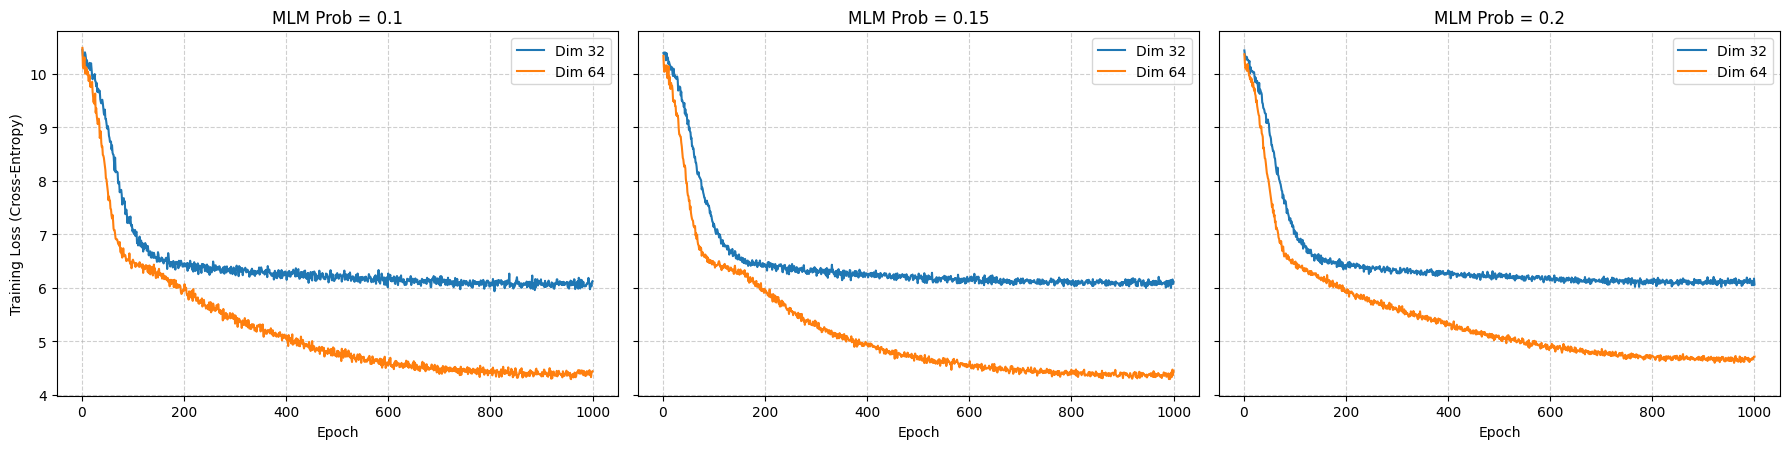

In [15]:
fig, axes = plt.subplots(1, len(mlm_probs), figsize=(18, 5), sharey=True) # sharey=True is key

# Adjust layout if only one subplot is needed (e.g., if mlm_probs has length 1)
if len(mlm_probs) == 1:
    axes = [axes] # Make it iterable

for i, prob in enumerate(mlm_probs):
    ax = axes[i]
    plot_successful = False # Flag to check if anything was plotted on this axis
    for dim_val in dims:
        record = all_records[prob].get(dim_val) # Use .get() for safety
        if record is not None and len(record) > 0:
            # Check if the record contains non-zero loss values before plotting
            # (Sometimes records might be initialized with zeros if saving started before training)
            if np.any(record != 0):
                 # Generate x-axis values (epochs)
                x_epochs = np.arange(1, len(record) + 1)
                ax.plot(x_epochs, record, label=f'Dim {dim_val}')
                plot_successful = True
            else:
                 print(f"Skipping plot for dim={dim_val}, prob={prob} as record contains only zeros.")
        else:
            print(f"Skipping plot for dim={dim_val}, prob={prob} due to loading error or empty record.")

    if plot_successful:
        ax.set_title(f'MLM Prob = {prob}')
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    else:
        ax.set_title(f'MLM Prob = {prob}\n(No data loaded)')
        ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Set Y-axis label only on the first plot
axes[0].set_ylabel('Training Loss (Cross-Entropy)')

#fig.suptitle('Comparison of Training Loss Across Model Dimensions and MLM Probabilities', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.savefig('training_loss_comparison.pdf')
plt.show()